In [1]:
from run_sim import run_sim
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# set up dataframe for collecting event data
mtd_stats, attack_stats = run_sim()

Target Node is:  91


INFO:root:Adversary: Start SCAN_HOST at 0.0s.
INFO:root:Adversary: Processed SCAN_HOST at 5.0s.
INFO:root:Adversary: Start ENUM_HOST at 5.0s.
INFO:root:Adversary: Processed ENUM_HOST at 7.0s.
INFO:root:Adversary: Start SCAN_PORT at 7.0s.
INFO:root:Adversary: Processed SCAN_PORT at 17.0s.
INFO:root:Adversary: Start EXPLOIT_VULN at 17.0s.
INFO:root:MTD: PortShuffle triggered 32.1s
INFO:root:MTD: PortShuffle deployed in the network at 32.1s.
INFO:root:Adversary: Processed EXPLOIT_VULN at 47.2s.
INFO:root:Adversary: Host 0 has been compromised at 47.2s!: 
INFO:root:Adversary: Start SCAN_NEIGHBOR at 47.2s.
INFO:root:Adversary: Processed SCAN_NEIGHBOR at 52.2s.
INFO:root:Adversary: Start ENUM_HOST at 52.2s.
INFO:root:Adversary: Processed ENUM_HOST at 54.2s.
INFO:root:Adversary: Start SCAN_PORT at 54.2s.
INFO:root:MTD: osdiversity triggered 62.1s
INFO:root:MTD: osdiversity suspended at 62.1s due to resource occupation
INFO:root:Adversary: Processed SCAN_PORT at 64.2s.
INFO:root:Adversary: Sta

In [3]:
print(mtd_stats.dict())
mtd_operation_record = pd.DataFrame(mtd_stats.mtd_operation_record)

mtd_operation_record

{'Total suspended MTD': 979, 'Total triggered MTD': 3279, 'Total executed MTD': 2299, 'Total attack interrupted': 233}


,name,start_time,finish_time,duration
0,PortShuffle,32.086513,72.588249,40.501736
1,osdiversity,93.148579,123.203747,30.055168
2,CompleteTopologyShuffle,123.270249,193.333195,70.062946
3,PortShuffle,244.353466,284.618114,40.264648
4,CompleteTopologyShuffle,214.350300,285.025626,70.675326
...,...,...,...,...
2294,CompleteTopologyShuffle,99706.510850,99778.056851,71.546002
2295,osdiversity,99797.581053,99827.801568,30.220515
2296,serviceDiversity,99858.433641,99898.770877,40.337236
2297,PortShuffle,99919.738596,99959.875658,40.137062


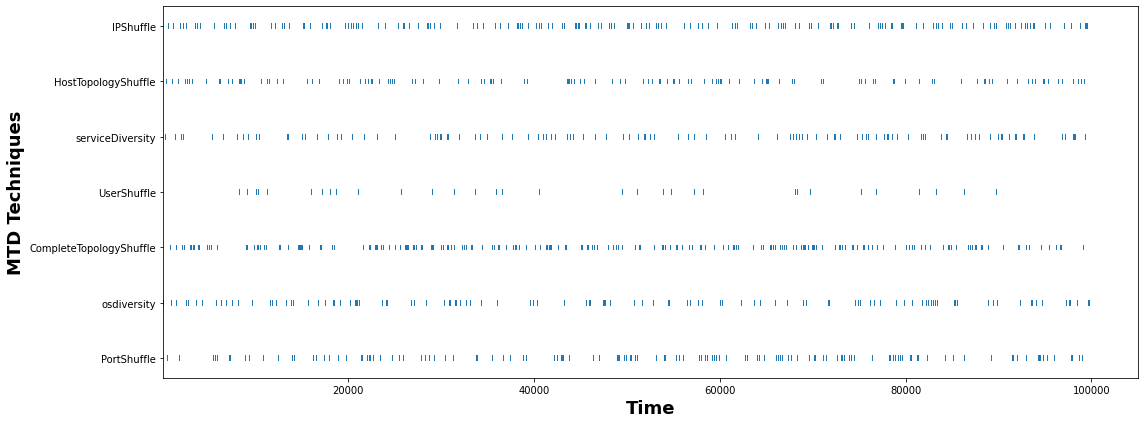

In [4]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.show()

In [5]:
attack_operation_record = pd.DataFrame(attack_stats.attack_operation_record)
attack_operation_record

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,cumulative_attempts,compromise_host,cumulative_compromised_hosts
0,SCAN_HOST,0.000000,5.000000,5.000000,,,-1,0,0,,0
1,ENUM_HOST,5.000000,7.000000,2.000000,,,-1,0,0,,0
2,SCAN_PORT,7.000000,17.000000,10.000000,,,0,1,0,,0
3,EXPLOIT_VULN,17.000000,47.151015,30.151015,,,0,1,0,0,0
4,SCAN_NEIGHBOR,47.151015,52.151015,5.000000,,,0,1,14,,1
...,...,...,...,...,...,...,...,...,...,...,...
1632,SCAN_PORT,13207.204871,13217.204871,10.000000,,,18,9,859,18,199
1633,SCAN_NEIGHBOR,13217.204871,13222.204871,5.000000,,,18,9,859,,200
1634,ENUM_HOST,13222.204871,13224.204871,2.000000,,,18,9,859,,200
1635,ENUM_HOST,13224.204871,13226.204871,2.000000,,,60,5,859,,200


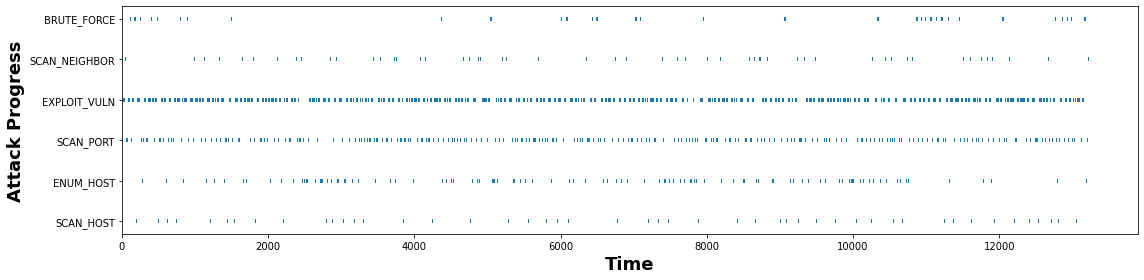

In [6]:
fig2, ax2 = plt.subplots(1, figsize=(16, 4))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.show()

In [7]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,cumulative_attempts,compromise_host,cumulative_compromised_hosts
22,SCAN_PORT,265.040628,275.040628,10.0,,,1,2,36,1,1
88,SCAN_PORT,977.875010,987.875010,10.0,,,41,1,145,41,8
133,SCAN_PORT,1411.774765,1421.774765,10.0,,,53,1,204,53,16
248,SCAN_PORT,2427.305137,2437.305137,10.0,,,27,1,381,27,30
463,SCAN_PORT,3743.496404,3753.496404,10.0,,,149,1,516,149,63
499,SCAN_PORT,4090.255305,4100.255305,10.0,,,101,1,566,101,69
512,SCAN_PORT,4185.718687,4195.718687,10.0,,,80,1,570,80,72
579,SCAN_PORT,4772.087372,4782.087372,10.0,,,109,2,646,109,80
594,SCAN_PORT,4864.301063,4874.301063,10.0,,,74,1,647,74,81
602,SCAN_PORT,4891.301063,4901.301063,10.0,,,125,1,647,125,82


In [8]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,cumulative_attempts,compromise_host,cumulative_compromised_hosts
3,EXPLOIT_VULN,17.000000,47.151015,30.151015,,,0,1,0,0,0
27,EXPLOIT_VULN,296.618114,327.523247,30.905133,,,25,1,36,25,2
49,EXPLOIT_VULN,571.064819,602.890083,31.825263,,,50,1,53,50,3
56,EXPLOIT_VULN,638.655450,669.237959,30.582508,,,36,1,67,36,4
64,EXPLOIT_VULN,709.090798,740.548500,31.457702,,,29,2,94,29,5
...,...,...,...,...,...,...,...,...,...,...,...
1526,EXPLOIT_VULN,12105.686194,12137.014098,31.327904,,,12,1,857,12,192
1541,EXPLOIT_VULN,12237.441722,12267.990005,30.548284,,,13,1,859,13,193
1559,EXPLOIT_VULN,12451.625773,12483.211828,31.586055,,,14,3,859,14,194
1572,EXPLOIT_VULN,12549.935256,12581.716058,31.780802,,,16,1,859,16,196


In [9]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,cumulative_attempts,compromise_host,cumulative_compromised_hosts


In [10]:
if not os.path.exists('data_analysis'):
    os.makedirs(os.path.dirname('data_analysis'))

attack_operation_record.to_csv('data_analysis/attack_operation_record.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record.csv', index=False)